In [1]:
!pip install laspy
!pip install laspy[lazrs]
!pip install laszip
!pip install open3d

In [47]:
import laspy
import numpy as np

# Load .las file
las = laspy.read("C:/Users/umair.muhammad/Documents/PhD/Research Work/FedLearn/training/site1/site1 las/Site1_1.las")

# Extract coordinates
points = np.vstack((las.x, las.y, las.z)).T
print(points.shape)  # (N, 3)


(306546, 3)


In [48]:
import open3d as o3d

# Create an Open3D point cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)

# Visualize the point cloud
o3d.visualization.draw_geometries([pcd])

In [49]:
import pandas as pd

regions = pd.read_csv("C:/Users/umair.muhammad/Documents/PhD/Research Work/FedLearn/training/site1/site1 csv/Site1_1.csv")
print(regions.head())

           Name           X            Y       Z
0  Site1_1_P1_S  452625.500  7183542.099  145.54
1  Site1_1_P1_F  452625.658  7183541.602  145.53
2  Site1_1_P2_S  452626.749  7183538.561  145.52
3  Site1_1_P2_F  452627.003  7183538.362  145.57
4  Site1_1_P3_S  452642.015  7183501.636  145.79


In [29]:
# Group start and end points
regions['Group'] = regions['Name'].str.extract(r'(Site\d+_\d+_P\d+)')

# Pivot start and end
damage_regions = regions.pivot(index='Group', columns='Name', values=['X', 'Y', 'Z'])

C:\Users\umair.muhammad\AppData\Local\Temp\ipykernel_56244\2253057948.py:5: FutureWarning: The behavior of Index.insert with object-dtype is deprecated, in a future version this will return an object-dtype Index instead of inferring a non-object dtype. To retain the old behavior, do `idx.insert(loc, item).infer_objects(copy=False)`
  damage_regions = regions.pivot(index='Group', columns='Name', values=['X', 'Y', 'Z'])


In [30]:
import laspy
import numpy as np
import pandas as pd
import h5py
import os

# ==== INPUT FILES ====
las_file = "C:/Users/umair.muhammad/Documents/PhD/Research Work/FedLearn/training/site1/site1 las/Site1_2.las"
txt_file = "C:/Users/umair.muhammad/Documents/PhD/Research Work/FedLearn/training/site1/site1 csv/Site1_2.csv"   # your .txt file with S/F lines
# Extract coordinates
points = np.vstack((las.x, las.y, las.z)).T
print(points.shape)  # (N, 3)

# ==== LOAD POINT CLOUD ====
las = laspy.read(las_file)
points = np.vstack((las.x, las.y, las.z)).T

# ==== LOAD DAMAGE COORDINATES ====
# Skip first 'Cartesian' line if it exists
with open(txt_file, 'r', encoding='utf-8', errors='ignore') as f:
    lines = [l for l in f.readlines() if not l.strip().startswith("Cartesian")]
from io import StringIO
df = pd.read_csv(StringIO("".join(lines)))

# Keep needed columns
df = df[["Name", "X", "Y", "Z"]]

# ==== BUILD DAMAGE BOXES ====
damage_boxes = []
for i in range(0, len(df), 2):  # assumes each S/F pair are consecutive
    name_start = df.iloc[i]["Name"]
    name_end   = df.iloc[i+1]["Name"]
    x1, y1, z1 = df.iloc[i][["X", "Y", "Z"]]
    x2, y2, z2 = df.iloc[i+1][["X", "Y", "Z"]]
    
    box = {
        'xmin': min(x1, x2),
        'xmax': max(x1, x2),
        'ymin': min(y1, y2),
        'ymax': max(y1, y2),
        'zmin': min(z1, z2),
        'zmax': max(z1, z2)
    }
    damage_boxes.append(box)

print(f"✅ Loaded {len(damage_boxes)} damage boxes")

# ==== LABEL POINTS ====
labels = np.zeros(len(points), dtype=int)

for box in damage_boxes:
    in_box = (
        (points[:,0] >= box['xmin']) & (points[:,0] <= box['xmax']) &
        (points[:,1] >= box['ymin']) & (points[:,1] <= box['ymax']) &
        (points[:,2] >= box['zmin']) & (points[:,2] <= box['zmax'])
    )
    labels[in_box] = 1  # mark as damaged

print(f"✅ Assigned {np.sum(labels)} damaged points out of {len(points)} total")

# ==== SAVE TO H5 ====
out_h5 = "C:/Users/umair.muhammad/Documents/PhD/Research Work/FedLearn/training/site1/road_damage_points.h5"
with h5py.File(out_h5, "w") as f:
    f.create_dataset("data", data=points)
    f.create_dataset("label", data=labels)

print(f"🎉 Saved labeled data to {out_h5}")


(356774, 3)
✅ Loaded 11 damage boxes
✅ Assigned 487 damaged points out of 356774 total
🎉 Saved labeled data to C:/Users/umair.muhammad/Documents/PhD/Research Work/FedLearn/training/site1/road_damage_points.h5


In [32]:
import open3d as o3d
import numpy as np

# Create an Open3D point cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)

# Assign colors based on labels
colors = np.zeros_like(points)
colors[labels == 0] = [0.5, 0.5, 0.5]  # Grey for undamaged points
colors[labels == 1] = [1, 0, 0]      # Red for damaged points

pcd.colors = o3d.utility.Vector3dVector(colors)

# Visualize the point cloud
o3d.visualization.draw_geometries([pcd])

In [33]:
print("Damage Box Dimensions and Point Counts:")
for i, box in enumerate(damage_boxes):
    x_dim = box['xmax'] - box['xmin']
    y_dim = box['ymax'] - box['ymin']
    z_dim = box['zmax'] - box['zmin']
    points_in_box_count = np.sum(
        (points[:,0] >= box['xmin']) & (points[:,0] <= box['xmax']) &
        (points[:,1] >= box['ymin']) & (points[:,1] <= box['ymax']) &
        (points[:,2] >= box['zmin']) & (points[:,2] <= box['zmax'])
    )
    print(f"Box {i+1}: X_dim={x_dim:.2f}, Y_dim={y_dim:.2f}, Z_dim={z_dim:.2f}, Points_count={points_in_box_count}")

Damage Box Dimensions and Point Counts:
Box 1: X_dim=0.45, Y_dim=0.41, Z_dim=0.02, Points_count=35
Box 2: X_dim=0.80, Y_dim=0.59, Z_dim=0.04, Points_count=70
Box 3: X_dim=0.38, Y_dim=0.14, Z_dim=0.02, Points_count=3
Box 4: X_dim=0.57, Y_dim=0.77, Z_dim=0.01, Points_count=72
Box 5: X_dim=1.09, Y_dim=0.34, Z_dim=0.03, Points_count=80
Box 6: X_dim=0.43, Y_dim=0.57, Z_dim=0.06, Points_count=95
Box 7: X_dim=0.39, Y_dim=0.37, Z_dim=0.01, Points_count=12
Box 8: X_dim=0.35, Y_dim=0.17, Z_dim=0.02, Points_count=9
Box 9: X_dim=1.00, Y_dim=0.48, Z_dim=0.02, Points_count=18
Box 10: X_dim=0.84, Y_dim=0.57, Z_dim=0.00, Points_count=36
Box 11: X_dim=0.83, Y_dim=0.43, Z_dim=0.05, Points_count=57


In [81]:
#Full Optimized Code (DBSCAN + Subsampling + Visualization)
import laspy
import numpy as np
import pandas as pd
import h5py
from io import StringIO
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import open3d as o3d

# ==== INPUT FILES ====
las_file = r"C:/Users/umair.muhammad/Documents/PhD/Research Work/FedLearn/training/site1/site1 las/Site1_14.las"
txt_file = r"C:/Users/umair.muhammad/Documents/PhD/Research Work/FedLearn/training/site1/site1 csv/Site1_14.csv"

# ==== LOAD POINT CLOUD ====
las = laspy.read(las_file)
points = np.vstack((las.x, las.y, las.z)).T
print(f"Total points: {points.shape[0]}")

# ==== LOAD DAMAGE COORDINATES ====
with open(txt_file, 'r', encoding='utf-8', errors='ignore') as f:
    lines = [l for l in f.readlines() if not l.strip().startswith("Cartesian")]
df = pd.read_csv(StringIO("".join(lines)))
df = df[["Name", "X", "Y", "Z"]]

# ==== BUILD DAMAGE BOXES ====
damage_boxes = []
for i in range(0, len(df), 2):  # assumes each S/F pair are consecutive
    x1, y1, z1 = df.iloc[i][["X", "Y", "Z"]]
    x2, y2, z2 = df.iloc[i + 1][["X", "Y", "Z"]]
    box = {
        'xmin': min(x1, x2), 'xmax': max(x1, x2),
        'ymin': min(y1, y2), 'ymax': max(y1, y2),
        'zmin': min(z1, z2), 'zmax': max(z1, z2)
    }
    damage_boxes.append(box)
print(f"✅ Loaded {len(damage_boxes)} damage boxes\n")

# ==== INITIAL LABELING + BOX STATS ====
labels = np.zeros(len(points), dtype=int)
subset_mask = np.zeros(len(points), dtype=bool)  # for spatial subsampling

margin = 0.3  # meters margin around labeled boxes
for idx, box in enumerate(damage_boxes):
    in_box = (
        (points[:, 0] >= box['xmin']) & (points[:, 0] <= box['xmax']) &
        (points[:, 1] >= box['ymin']) & (points[:, 1] <= box['ymax']) &
        (points[:, 2] >= box['zmin']) & (points[:, 2] <= box['zmax'])
    )
    labels[in_box] = 1  # mark inside box as damaged

    # create larger mask around each box
    around_box = (
        (points[:, 0] >= box['xmin'] - margin) & (points[:, 0] <= box['xmax'] + margin) &
        (points[:, 1] >= box['ymin'] - margin) & (points[:, 1] <= box['ymax'] + margin) &
        (points[:, 2] >= box['zmin'] - margin) & (points[:, 2] <= box['zmax'] + margin)
    )
    subset_mask |= around_box

    count = np.sum(in_box)
    x_len = box['xmax'] - box['xmin']
    y_len = box['ymax'] - box['ymin']
    z_len = box['zmax'] - box['zmin']
    print(f"Box {idx+1}: Size = ({x_len:.3f}, {y_len:.3f}, {z_len:.3f}) m | Points inside = {count}")

initial_damage_idx = np.where(labels == 1)[0]
print(f"\n✅ Initial damage points: {len(initial_damage_idx)}")
print(f"✅ Subset region points (around boxes): {np.sum(subset_mask)}\n")

# ==== DBSCAN REFINEMENT on Subset ====
subset_points = points[subset_mask]
subset_labels = np.zeros(len(subset_points), dtype=int)

# Normalize subset for density-based clustering
scaler = StandardScaler()
scaled_subset = scaler.fit_transform(subset_points)

# --- DBSCAN parameters (tune as needed) ---
eps = 0.05        # neighborhood radius (scaled space)
min_samples = 15  # min points in cluster

db = DBSCAN(eps=eps, min_samples=min_samples, algorithm='ball_tree').fit(scaled_subset)
cluster_labels = db.labels_

# propagate cluster labels to full cloud
subset_indices = np.where(subset_mask)[0]
for c in np.unique(cluster_labels):
    if c == -1:
        continue
    cluster_idx = subset_indices[cluster_labels == c]
    if np.any(labels[cluster_idx] == 1):  # overlap with labeled damage
        labels[cluster_idx] = 1

print(f"🎯 Refined damage points: {np.sum(labels)} out of {len(points)} total")

# ==== SAVE LABELED DATA ====
out_h5 = r"C:/Users/umair.muhammad/Documents/PhD/Research Work/FedLearn/training/site1/DBSCAN/road_damage_points_14.h5"
with h5py.File(out_h5, "w") as f:
    f.create_dataset("data", data=points)
    f.create_dataset("label", data=labels)
print(f"💾 Saved refined labeled data to {out_h5}")


Total points: 415143
✅ Loaded 15 damage boxes

Box 1: Size = (0.264, 0.151, 0.030) m | Points inside = 40
Box 2: Size = (0.207, 0.108, 0.010) m | Points inside = 25
Box 3: Size = (0.310, 0.163, 0.020) m | Points inside = 42
Box 4: Size = (0.591, 0.393, 0.010) m | Points inside = 158
Box 5: Size = (0.270, 0.115, 0.030) m | Points inside = 47
Box 6: Size = (1.459, 1.493, 0.010) m | Points inside = 1376
Box 7: Size = (0.528, 0.290, 0.000) m | Points inside = 79
Box 8: Size = (1.722, 2.934, 0.010) m | Points inside = 1964
Box 9: Size = (0.661, 0.574, 0.020) m | Points inside = 194
Box 10: Size = (0.545, 0.182, 0.000) m | Points inside = 0
Box 11: Size = (0.939, 0.669, 0.740) m | Points inside = 77
Box 12: Size = (1.279, 1.182, 0.020) m | Points inside = 36
Box 13: Size = (0.300, 0.112, 0.010) m | Points inside = 18
Box 14: Size = (0.297, 0.142, 0.010) m | Points inside = 7
Box 15: Size = (1.892, 5.877, 0.070) m | Points inside = 10943

✅ Initial damage points: 15006
✅ Subset region points 

In [69]:

# ==== 3D VISUALIZATION ====
damaged_points = points[labels == 1]
undamaged_points = points[labels == 0]

print("\n🟢 Opening 3D visualization...")
print(f"Damaged points: {len(damaged_points)}, Undamaged: {len(undamaged_points)}")

pcd_damaged = o3d.geometry.PointCloud()
pcd_damaged.points = o3d.utility.Vector3dVector(damaged_points)
pcd_damaged.paint_uniform_color([1, 0, 0])  # red

pcd_undamaged = o3d.geometry.PointCloud()
pcd_undamaged.points = o3d.utility.Vector3dVector(undamaged_points)
pcd_undamaged.paint_uniform_color([0.6, 0.6, 0.6])  # gray

o3d.visualization.draw_geometries(
    [pcd_undamaged, pcd_damaged],
    window_name="Road Damage (Subset-Refined)",
    width=1200, height=800
)



🟢 Opening 3D visualization...
Damaged points: 6373, Undamaged: 350401


In [21]:
!pip install h5py

Points shape: (356774, 3)
Labels shape: (356774,)
Unique labels: [0 1]


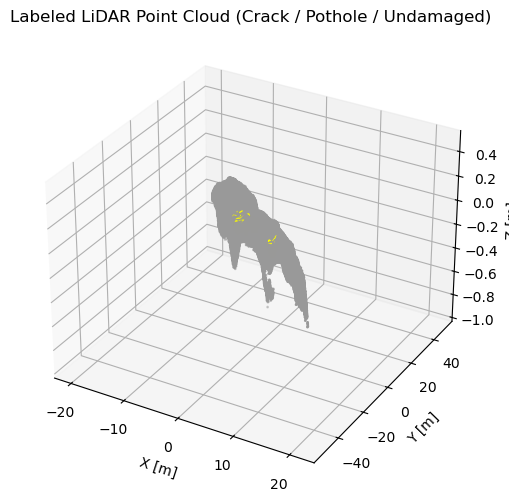

In [70]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- Load data ---
with h5py.File("C:/Users/umair.muhammad/Documents/PhD/Research Work/FedLearn/training/site1/DBSCAN/road_damage_points_2.h5", "r") as f:
    points = np.array(f["data"])
    labels = np.array(f["label"])

print("Points shape:", points.shape)
print("Labels shape:", labels.shape)
print("Unique labels:", np.unique(labels))

# --- Assign colors ---
# Adjust color mapping based on your label scheme:
# 0 = undamaged (gray), 1 = crack (yellow), 2 = pothole (red)
colors = np.array([[0.6, 0.6, 0.6], [1, 1, 0], [1, 0, 0]])
c = np.array([colors[int(l)] for l in labels])

# --- Normalize for display ---
points -= np.mean(points, axis=0)

# --- 3D Scatter Visualization ---
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:,0], points[:,1], points[:,2], c=c, s=1)
ax.set_title("Labeled LiDAR Point Cloud (Crack / Pothole / Undamaged)")
ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
ax.set_zlabel("Z [m]")
plt.show()